# PaperCompanion5 - Stochastic Learning in Policy Space
Notebook to generate the first part of figure 5 of the paper, depicting the approximated 4D deterministic learning trajectories in a constructed 3D space. The time evolution is reflected in the color gradient of the trajectories.

In [1]:
# import general libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap
from scipy.optimize import fsolve
import os
# import own functions
from agent_game_sim import reward_matrix_for_two_player_PD
from agent_game_sim import get_individual_matrices
from agent_game_sim import generate_q_values
from agent_game_sim import calculate_fixed_point_policy
from agent_game_sim import calculate_target_Q_values
from agent_game_sim import calculate_eigenvalues_and_eigenvectors

In [2]:
class DeterministicAgent():
    def __init__(self, Q_values_initial, learning_rate, discount_factor, temperature):
        self.Q_values_initial = Q_values_initial
        self.Q_values = Q_values_initial
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.temperature = temperature
        self.Q_values_history = []         # history of Q-values
        self.prob_vector_history = []        # history of probabilities

    def get_prob_vector(self):
        return np.exp(self.Q_values / self.temperature) / np.sum(np.exp(self.Q_values / self.temperature))
    
    def update_history(self):
        self.Q_values_history.append(self.Q_values)
        self.prob_vector_history.append(self.get_prob_vector())

    def reset(self):
        self.Q_values = self.Q_values_initial

def deterministic_QL_step(agents, reward_matrices):
    '''Deterministic Q-learning step for a symmetric 2x2 repeated normal-form game for two agents'''
    # update history
    for agent in agents:
        agent.update_history()

    # get the probability vector of the agents
    agent_1, agent_2 = agents
    prob_vector_agent_1 = agent_1.get_prob_vector()
    prob_vector_agent_2 = agent_2.get_prob_vector()

    # get the reward matrices
    reward_matrix_A, reward_matrix_B = reward_matrices
    
    # update the Q-values via deterministic equation
    Q_vector_new_1 = agent_1.Q_values + agent_1.learning_rate * prob_vector_agent_1 * (reward_matrix_A @ prob_vector_agent_2 + agent_1.discount_factor * np.max(agent_1.Q_values) - agent_1.Q_values)
    Q_vector_new_2 = agent_2.Q_values + agent_2.learning_rate * prob_vector_agent_2 * (prob_vector_agent_1 @ reward_matrix_B + agent_2.discount_factor * np.max(agent_2.Q_values) - agent_2.Q_values)

    # update the Q-values
    agent_1.Q_values = Q_vector_new_1
    agent_2.Q_values = Q_vector_new_2

Run finished for initial probability pair (0.1, 0.9) Progress: 1/11
Run finished for initial probability pair (0.5, 0.9) Progress: 2/11
Run finished for initial probability pair (0.7, 0.9) Progress: 3/11
Run finished for initial probability pair (0.9, 0.9) Progress: 4/11
Run finished for initial probability pair (0.9, 0.7) Progress: 5/11
Run finished for initial probability pair (0.1, 0.5) Progress: 6/11
Run finished for initial probability pair (0.5, 0.5) Progress: 7/11
Run finished for initial probability pair (0.9, 0.5) Progress: 8/11
Run finished for initial probability pair (0.1, 0.1) Progress: 9/11
Run finished for initial probability pair (0.5, 0.1) Progress: 10/11
Run finished for initial probability pair (0.9, 0.1) Progress: 11/11


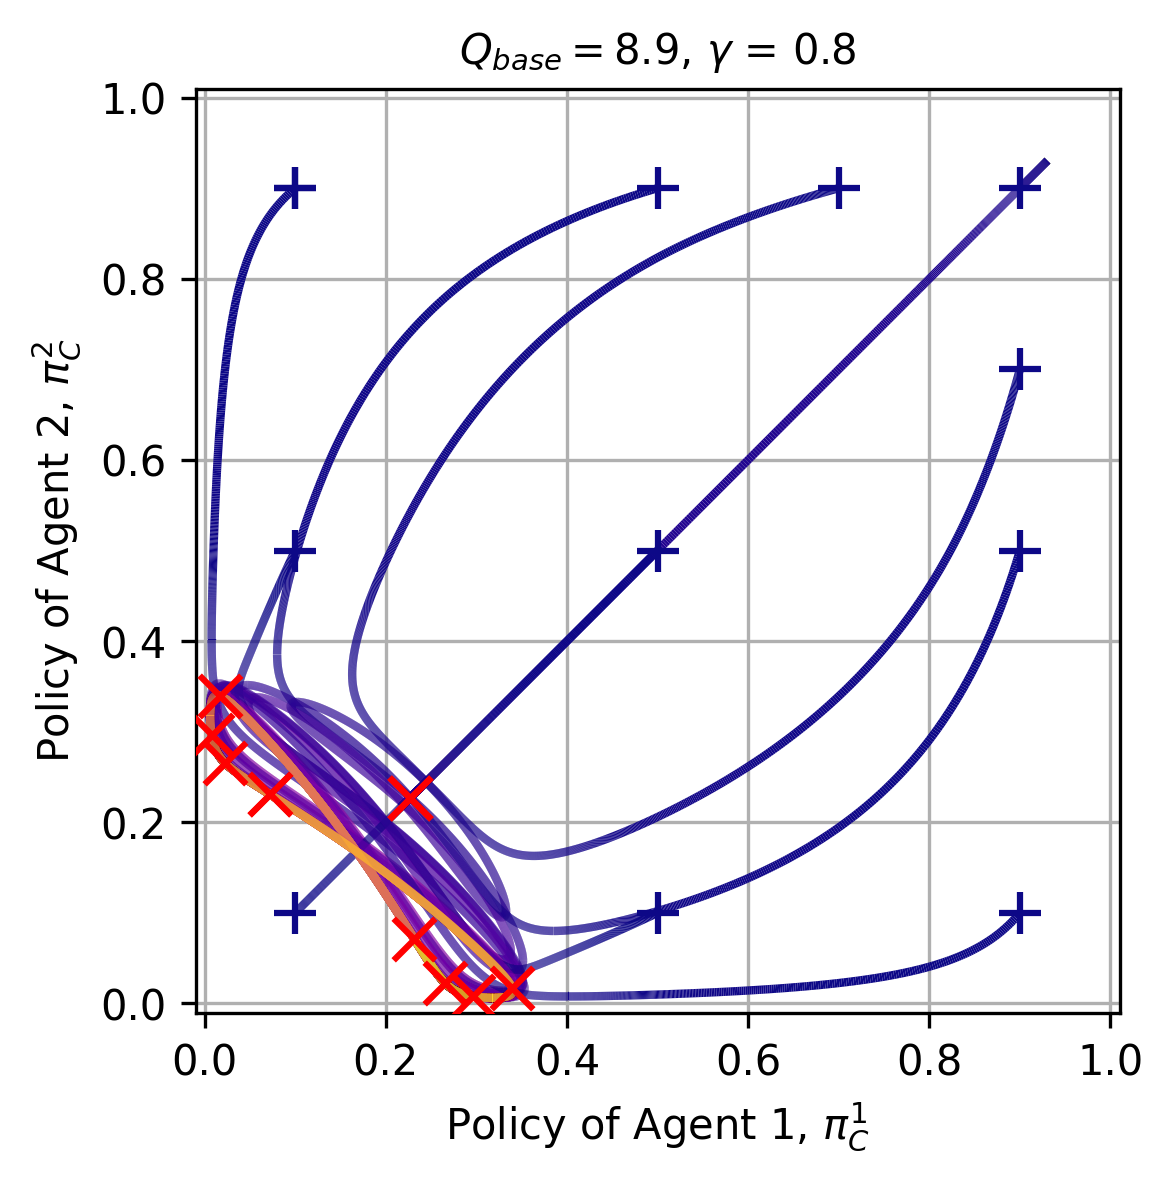

In [3]:
# enable inline plotting
%matplotlib inline
# plotting settings
directory_for_figures = 'PaperFigures' # directory for saving the figures
if not os.path.exists(directory_for_figures):
    os.makedirs(directory_for_figures)
figsize = (4, 4)
dpi = 300
plot_colorbar = False

reward_function = reward_matrix_for_two_player_PD
game_title = 'Prisoner\'s Dilemma'
first_action_title = 'Cooperation'
reward_matrices = get_individual_matrices(reward_function)

# Define learning parameters
learning_rate = 0.01
discount_factor = 0.8
temperature = 1

# calculate the fixed point policy, the target Q-values and eigenvalues and eigenvectors
fixed_point_policy = calculate_fixed_point_policy(temperature, discount_factor, print_solution = False)
Q_target_C, Q_target_D = calculate_target_Q_values(fixed_point_policy, discount_factor)
eigenvalues, eigenvectors = calculate_eigenvalues_and_eigenvectors(discount_factor, temperature, learning_rate, print_solution = False)

# Define base value around which the Q-values are centered if given initial probabilities
base_value = Q_target_C + (Q_target_D - Q_target_C)/2  #0 * 1/(1-discount_factor)

# set the number of time steps 
num_time_steps = int(3e4)

# generate initial probability pairs for the complete 1x1 square in policy space
initial_probability_pairs = [(0.1, 0.9), (0.5, 0.9), (0.7,0.9), (0.9, 0.9), (0.9,0.7),
                        (0.1, 0.5), (0.5, 0.5), (0.9, 0.5),
                        (0.1, 0.1), (0.5, 0.1), (0.9, 0.1)]

# Plot the dynamics in policy space
fig = plt.figure(figsize=figsize, dpi=dpi)
plot_time_evolution = True
label_flag_added = False # Flag to add labels only once
marker_size = 100
color_start_scatter = plt.cm.plasma(0.0) # dark purple
color_end_scatter = 'red' #plt.cm.plasma(1.0) # bright yellow

# store outcomes in lists
delta_Q_history_agent_0_list = []
delta_Q_history_agent_1_list = []
sum_Q_history_list = []
diff_deltaQ_agent0_deltaQ_agent1_list = []
diff_Q_agent0_agent1_list = []
# loop over all initial probability pairs
for i, initial_probability_pair in enumerate(initial_probability_pairs):
    # generate the initial Q-values for the agents from the initial probabilities centered around the base value
    Q_values_initial_list = [generate_q_values(probability, temperature, base_value) for probability in initial_probability_pair]

    # define the agents
    agents = [DeterministicAgent(Q_values_initial, learning_rate, discount_factor, temperature) for Q_values_initial in Q_values_initial_list]
    
    # run deterministic Q-learning model
    for time_step in range(num_time_steps):
        deterministic_QL_step(agents, reward_matrices)
    print("Run finished for initial probability pair", initial_probability_pair, f"Progress: {i+1}/{len(initial_probability_pairs)}")

    # extract relevant information of 4D dynamics in order to plot in lower dimensions
    delta_Q_history_agent_0 = np.array([Q_values[0] - Q_values[1] for Q_values in agents[0].Q_values_history])
    delta_Q_history_agent_1 = np.array([Q_values[0] - Q_values[1] for Q_values in agents[1].Q_values_history])
    sum_Q_history = np.array([np.sum(Q_values) for Q_values in agents[0].Q_values_history]) + np.array([np.sum(Q_values) for Q_values in agents[1].Q_values_history])
    diff_deltaQ_agent0_deltaQ_agent1 = delta_Q_history_agent_0 - delta_Q_history_agent_1
    diff_Q_agent0_agent1 = np.array([np.sum(Q_values) for Q_values in agents[0].Q_values_history]) - np.array([np.sum(Q_values) for Q_values in agents[1].Q_values_history]) # difference between the sum of Q-values of both agents

    # store outcomes in lists
    delta_Q_history_agent_0_list.append(delta_Q_history_agent_0)
    delta_Q_history_agent_1_list.append(delta_Q_history_agent_1)
    sum_Q_history_list.append(sum_Q_history)
    diff_deltaQ_agent0_deltaQ_agent1_list.append(diff_deltaQ_agent0_deltaQ_agent1)
    diff_Q_agent0_agent1_list.append(diff_Q_agent0_agent1)

    # plot only every n-th time step to reduce the number of lines
    n = 1
    # get the histories of probabilities to cooperate for each agent 
    prob_coop_of_agent_1_list = [vector[0] for vector in agents[0].prob_vector_history[::n]]
    prob_coop_of_agent_2_list = [vector[0] for vector in agents[1].prob_vector_history[::n]]

    # combine for each time steps the probabilities of both agents so that we can plot in the 1x1 square of policy space
    prob_coop_list = np.array([prob_coop_of_agent_1_list, prob_coop_of_agent_2_list]).T

    if plot_time_evolution:
        # Create a list of lines to plot the time evolution of the trajectories with a color gradient
        lines = [ [prob_coop_list[i], prob_coop_list[i+1]] for i in range(len(prob_coop_list)-1)]
        # Create a LineCollection
        lc = LineCollection(lines, cmap='plasma', linewidths=2, alpha=1)
        # Set the colors of the lines
        lc.set_array(np.linspace(0, 1, len(prob_coop_list)))
        # Add the LineCollection to the plot
        plt.gca().add_collection(lc)

        # Add a colorbar for the time evolution ONLY ONCE
        if i == 0 and plot_colorbar:
            cbar = plt.colorbar(lc, fraction=0.046, pad=0.04)
            cbar.set_label('time steps')
            # lc is normalized so we need to set the ticks manually
            tick_values = [0, 1]
            tick_labels = [0, num_time_steps]
            cbar.set_ticks(tick_values)  # Set the ticks to the desired positions
            # Format tick labels into scientific notation manually
            cbar.set_ticklabels(["{:.0e}".format(tick_label) for tick_label in tick_labels])
    else:
        # plot dynamics in policy-space in the 1x1 square
        plt.plot(prob_coop_list[:, 0], prob_coop_list[:, 1], alpha = 1)

    # plot start and end points of the trajectories
    plt.scatter(prob_coop_list[0, 0], prob_coop_list[0, 1], marker='+', color=color_start_scatter, zorder=10, s=marker_size)
    plt.scatter(prob_coop_list[-1, 0], prob_coop_list[-1, 1], marker='x', color=color_end_scatter, zorder=10, s=marker_size)
    # add labels only once
    if not label_flag_added:
        plt.scatter(prob_coop_list[0, 0], prob_coop_list[0, 1], marker='+', color=color_start_scatter, label='Start', s=marker_size)
        plt.scatter(prob_coop_list[-1, 0], prob_coop_list[-1, 1], marker='x', color=color_end_scatter, label='End', s=marker_size)
        label_flag_added = True

# add cosmetics to the plot
fontsize = None#12
if plot_time_evolution:
    title = (r'$Q_{base} =$' + f'{base_value:.1f}, '+f'$\\gamma$ = {discount_factor}')
    plt.title(title, wrap=True, horizontalalignment='center', fontsize=fontsize)
else:
    caption = (f'$\\alpha$ = {learning_rate}, T = {temperature}, $\\gamma$ = {discount_factor}\n'
                f'Q-values are initialised around {base_value:.2f}.'
                f'\nTrajectories span {num_time_steps:.0e} time steps.\n'
            )
    plt.figtext(0.5, -0.1, caption, wrap=True, horizontalalignment='center', fontsize=fontsize)
    
# set axis labels
plt.xlabel(f'Policy of Agent 1, $\pi^1_{first_action_title[0]}$', fontsize=fontsize)
plt.ylabel(f'Policy of Agent 2, $\pi^2_{first_action_title[0]}$', fontsize=fontsize)
# set ticks of label to fontsize
ticks = [0, 0.2, 0.4, 0.6, 0.8, 1]
plt.xticks(ticks=ticks, fontsize=fontsize)
plt.yticks(ticks=ticks, fontsize=fontsize)
# fix x and y axis to unit square
plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01)
plt.grid()
# Ensure the axes are symmetrically scaled
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

# save figure
plt.savefig(os.path.join(directory_for_figures, f'Fig5_PD_DeterministicDynamics_discount_{discount_factor}_Qbase_{base_value:.2f}_temp_{temperature}_learningRate_{learning_rate}_numTimeSteps_{num_time_steps}.jpg'), dpi=300, bbox_inches='tight')
plt.show()

x_min: -5.105940911700122, x_max: -0.6607452235853151, y_min: -5.105940911700122, y_max: -0.6607452235853151, z_min: -7.732704451282455, z_max: 7.732704451282455


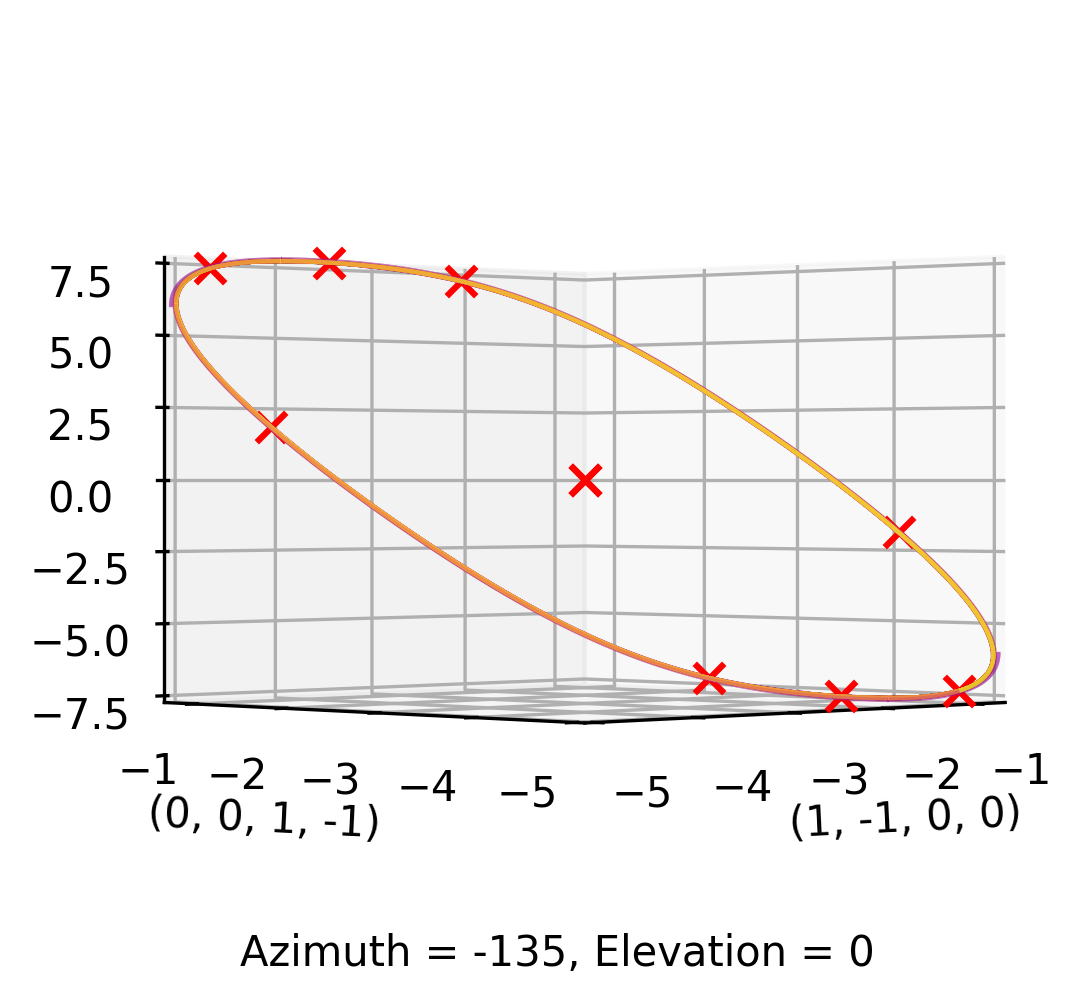

In [ ]:
# Enable interactive plotting for 3D plot
%matplotlib inline

# Here you can adjust the view angle of the plot:
azim, elev = -135, 0 # We plot either azim = -135, elev = 0 or azim = -105, elev = 45 in the paper
# Here you can set the percentage of the last time steps to plot. For example, 0.66 means that the last 66% of the time steps are plotted. For azim = -135, elev = 0 and a discount factor of 0.7 and 0.8, we plot only the last 66% of the time steps, for 0.97 we plot 100%.
percentage_to_plot = 0.66 

# plot the dynamics in a 3D plot.
fig = plt.figure(figsize=figsize, dpi=dpi)
ax = fig.add_subplot(111, projection='3d')
plot_time_evolution = True
# loop over all initial probability pairs
for i, initial_probability_pair in enumerate(initial_probability_pairs):
    # take only the last % of the data points to plot
    num_time_steps_to_plot = int(percentage_to_plot * num_time_steps)

    # get the data for the 3D plot from the lists
    delta_Q_history_agent_0 = delta_Q_history_agent_0_list[i][-num_time_steps_to_plot:]
    delta_Q_history_agent_1 = delta_Q_history_agent_1_list[i][-num_time_steps_to_plot:]
    sum_Q_agent0_agent1 = sum_Q_history_list[i][-num_time_steps_to_plot:]
    diff_Q_agent0_agent1 = diff_Q_agent0_agent1_list[i][-num_time_steps_to_plot:]
    diff_deltaQ_agent0_deltaQ_agent1 = diff_deltaQ_agent0_deltaQ_agent1_list[i][-num_time_steps_to_plot:]
    # Define a dictionary mapping variables to their names
    axis_label_names = {
        '(1, -1, 0, 0)': delta_Q_history_agent_0,
        '(0, 0, 1, -1)': delta_Q_history_agent_1,
        'Sum of Q values': sum_Q_agent0_agent1,
        '(1, -1, 1, -1)': diff_deltaQ_agent0_deltaQ_agent1,
        '(1, 1, -1, -1)': diff_Q_agent0_agent1
    }

    # choose axes for the 3D plot
    x = delta_Q_history_agent_0
    y = delta_Q_history_agent_1
    z = diff_Q_agent0_agent1
    
    if plot_time_evolution:
        # Create a list of lines to plot the time evolution of the trajectories with a color gradient
        resolution = 1
        lines = [ [(x[j], y[j], z[j]) , (x[j+resolution], y[j+resolution], z[j+resolution])] for j in range(len(x)-resolution) ]
        # create a custom colormap that displays plasma from 1 - percentage_to_plot to 1
        colors = plt.cm.plasma(np.linspace(1 - percentage_to_plot, 1, 256))
        custom_plasma = LinearSegmentedColormap.from_list('custom_plasma', colors)

        # Create a Line3DCollection
        lc = Line3DCollection(lines, cmap=custom_plasma, linewidths=1, alpha=1, zorder=2)
        # Set the colors of the lines
        lc.set_array(np.linspace(0, 1, num_time_steps_to_plot-1))
        # Add the LineCollection to the plot
        ax.add_collection3d(lc)

        # Add a colorbar for the time evolution ONLY ONCE
        if i == 0 and plot_colorbar:
            # start the colorbar at 1 - percentage_to_plot to get the color of the first time step right. The end should be 1, but the start is not 0, but 1 - percentage_to_plot

            cbar = plt.colorbar(lc, fraction=0.046, pad=0.04)
            cbar.set_label('time steps')
            # lc is normalized so we need to set the ticks manually
            if percentage_to_plot != percentage_to_plot:
                tick_values = [np.round(1-percentage_to_plot, 2), 1]
            else:
                tick_values = [0, 1]
            tick_labels = [(num_time_steps - num_time_steps_to_plot), num_time_steps]
            cbar.set_ticks(tick_values)
            # Format tick labels into scientific notation manually
            cbar.set_ticklabels(["{:.0e}".format(tick_label) for tick_label in tick_labels])
    else:
        ax.plot(x, y, z)
        
    # plot the initial and final points
    marker_size = 50
    if percentage_to_plot == 1:
        ax.scatter(x[0], y[0], z[0], marker='+', color=plt.cm.plasma(1 - percentage_to_plot), s = marker_size, zorder=1)
    ax.scatter(x[-1], y[-1], z[-1], marker='x', color=color_end_scatter, s = marker_size, zorder=100)

# add cosmetics to the plot
ax.set_xlabel([name for name, values in axis_label_names.items() if values is x][0])
ax.set_ylabel([name for name, values in axis_label_names.items() if values is y][0])
ax.set_zlabel([name for name, values in axis_label_names.items() if values is z][0])
# set axis to min and max values of all trajectories
x_min, x_max = min([min(x[-num_time_steps_to_plot:]) for x in delta_Q_history_agent_0_list]), max([max(x[-num_time_steps_to_plot:]) for x in delta_Q_history_agent_0_list]) 
y_min, y_max = min([min(y[-num_time_steps_to_plot:]) for y in delta_Q_history_agent_1_list]), max([max(y[-num_time_steps_to_plot:]) for y in delta_Q_history_agent_1_list])
z_min, z_max = min([min(z[-num_time_steps_to_plot:]) for z in diff_Q_agent0_agent1_list]), max([max(z[-num_time_steps_to_plot:]) for z in diff_Q_agent0_agent1_list])
print(f"x_min: {x_min}, x_max: {x_max}, y_min: {y_min}, y_max: {y_max}, z_min: {z_min}, z_max: {z_max}")
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_zlim(z_min, z_max)
ax.view_init(elev=elev, azim=azim)

caption = (f'Azimuth = {azim}, Elevation = {elev}') 
if azim == -135 and elev == 0:
    plt.figtext(0.5, 0.1, caption, wrap=True, horizontalalignment='center')
else:
    plt.figtext(0.5, 0.0, caption, wrap=True, horizontalalignment='center')

# save figure
save_path = os.path.join(directory_for_figures, f"Fig5_3D_plot_azi_{azim}_elev_{elev}_percentage_{percentage_to_plot}_{game_title}_alpha_{learning_rate}_T_{temperature}_gamma_{discount_factor}.jpg")
plt.savefig(save_path, dpi=dpi, bbox_inches='tight', facecolor='white')
plt.show()